# Import Libraries

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from persona_generator import generate_persona_labels

## Read required Data

In [3]:
df_scaled = pd.read_csv('../processed/processed_customers.csv')

In [4]:
df_unscaled = pd.read_csv('../processed/processed_customers_unscaled.csv')

# DBSCAN Algorithm

## Find Optimal Value for *eps*

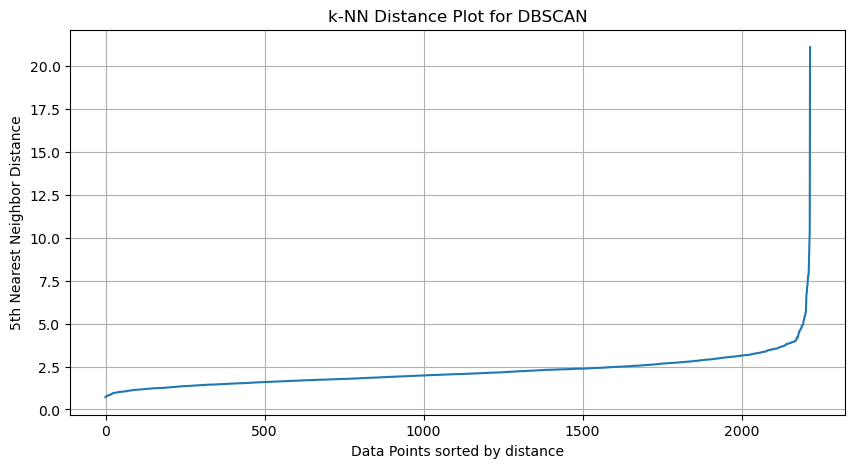

In [5]:
# Find the optimal epsilon using k-nearest neighbors
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(df_scaled)
distances, indices = neighbors.kneighbors(df_scaled)

# Sort the distances to find the "elbow" point
distance_desc = np.sort(distances[:, 4])
plt.figure(figsize=(10, 5))
plt.plot(distance_desc)
plt.title("k-NN Distance Plot for DBSCAN")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid()
plt.show()

Let's take *eps* = 4.0

In [6]:
dbscan = DBSCAN(eps=4.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

# Add DBSCAN cluster labels to the DataFrame
df_scaled['DBSCAN_Cluster'] = dbscan_labels

# Check distribution of clusters
print(df_scaled['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
 0    2120
 1      53
-1      27
 2      16
Name: count, dtype: int64


## Visualization of Clusters in 3D

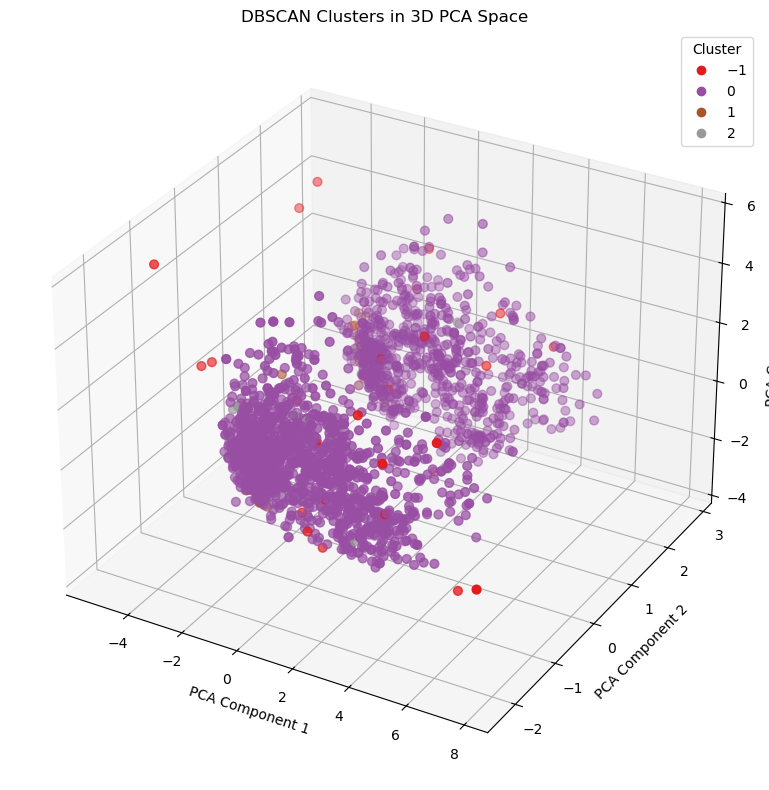

In [7]:
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(df_scaled.drop('DBSCAN_Cluster', axis=1))

# Prepare 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Map clusters to colors
scatter = ax.scatter(
    pca_result_3d[:, 0], pca_result_3d[:, 1], pca_result_3d[:, 2],
    c=df_scaled['DBSCAN_Cluster'],
    cmap='Set1',
    s=40
)

# Axis labels
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title("DBSCAN Clusters in 3D PCA Space")

# Legend
legend_labels = list(set(df_scaled['DBSCAN_Cluster']))
ax.legend(*scatter.legend_elements(), title="Cluster")

plt.tight_layout()
plt.show()

In [8]:
df_unscaled['Cluster'] = df_scaled['DBSCAN_Cluster']
df_unscaled.to_csv('../processed/dbscan.csv', index = False)

# Cluster Summary

In [9]:
cluster_summary = df_unscaled.groupby('Cluster').mean(numeric_only=True)

In [10]:
cluster_std = df_unscaled.groupby('Cluster').std(numeric_only=True)
cluster_std

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Customer_Tenure,Total_Spend,Family_Size,Total_Campaigns_Accepted,Age
Cluster,,,,,,,,,,,,,,
-1,130642.136304,30.658211,6.031966,7.870751,9.412364,2.888725,7.433657,0.395847,0.362014,216.910323,693.936974,0.800641,0.724028,26.897717
0,20109.605054,29.004380,1.822582,2.618638,2.757356,3.226204,2.302373,0.000000,0.361269,201.957766,603.913507,0.751620,0.686808,11.591155
1,5975.519439,26.204247,0.987954,0.840727,0.637484,0.647648,1.437624,0.000000,0.192380,208.262558,65.137022,0.524439,0.319878,11.636051
2,18814.132463,29.664724,1.460593,3.140462,2.473190,3.518996,2.372586,0.000000,0.000000,189.269462,385.271025,0.793200,0.000000,13.132656


In [11]:
for cluster in sorted(df_unscaled['Cluster'].unique()):
    print(f"Cluster {cluster} Summary:")
    print(cluster_summary.loc[cluster])
    print("\n---\n")

Cluster -1 Summary:
Income                      90301.481481
Recency                        49.814815
NumDealsPurchases               4.333333
NumWebPurchases                 4.444444
NumCatalogPurchases             5.148148
NumStorePurchases               1.962963
NumWebVisitsMonth               6.481481
Complain                        0.185185
Response                        0.148148
Customer_Tenure               337.629630
Total_Spend                   599.296296
Family_Size                     1.777778
Total_Campaigns_Accepted        0.296296
Age                            51.444444
Name: -1, dtype: float64

---

Cluster 0 Summary:
Income                      52637.743396
Recency                        49.017925
NumDealsPurchases               2.311792
NumWebPurchases                 4.144811
NumCatalogPurchases             2.702830
NumStorePurchases               5.929245
NumWebVisitsMonth               5.262736
Complain                        0.000000
Response                    

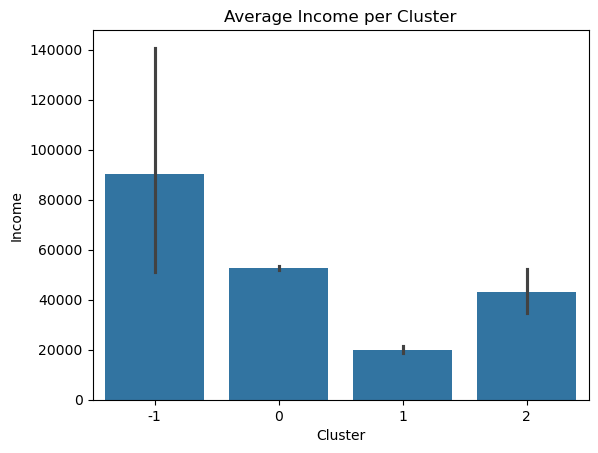

In [12]:
sns.barplot(x='Cluster', y='Income', data=df_unscaled)
plt.title('Average Income per Cluster')
plt.show()

## Insight ranges for each Cluster

In [13]:
for cluster in cluster_summary.index:
    print(f"\nInsights for Cluster {cluster}:\n")
    print('Range shown as (mean ± std)')
    
    for col in cluster_summary.columns:
        mean = cluster_summary.loc[cluster, col]
        std = cluster_std.loc[cluster, col]
        
        lower = int(round(mean - std))
        upper = int(round(mean + std))

        # Ensure lower is not greater than upper due to small std
        if lower > upper:
            lower, upper = upper, lower
        
        print(f"- {col}: approx. range {lower} to {upper}")
    
    print("\n" + "-"*60)



Insights for Cluster -1:

Range shown as (mean ± std)
- Income: approx. range -40341 to 220944
- Recency: approx. range 19 to 80
- NumDealsPurchases: approx. range -2 to 10
- NumWebPurchases: approx. range -3 to 12
- NumCatalogPurchases: approx. range -4 to 15
- NumStorePurchases: approx. range -1 to 5
- NumWebVisitsMonth: approx. range -1 to 14
- Complain: approx. range 0 to 1
- Response: approx. range 0 to 1
- Customer_Tenure: approx. range 121 to 555
- Total_Spend: approx. range -95 to 1293
- Family_Size: approx. range 1 to 3
- Total_Campaigns_Accepted: approx. range 0 to 1
- Age: approx. range 25 to 78

------------------------------------------------------------

Insights for Cluster 0:

Range shown as (mean ± std)
- Income: approx. range 32528 to 72747
- Recency: approx. range 20 to 78
- NumDealsPurchases: approx. range 0 to 4
- NumWebPurchases: approx. range 2 to 7
- NumCatalogPurchases: approx. range 0 to 5
- NumStorePurchases: approx. range 3 to 9
- NumWebVisitsMonth: approx.

## Assign Persona to each Cluster

In [39]:
labels = generate_persona_labels(cluster_summary)

In [41]:
for cluster, label in labels.items():
    print(f"Cluster {cluster}: {label}")

Cluster -1: High-Income, Moderate Spender, Complainers, Digital Shoppers, Middle-Aged, Small Households
Cluster 0: Middle-Income, Moderate Spender, No Complaints, Middle-Aged, Small Households
Cluster 1: Low-Income, Low Spender, No Complaints, Digital Shoppers, Middle-Aged, Small Households
Cluster 2: Middle-Income, Moderate Spender, Not Responsive to Campaigns, Complainers, Middle-Aged, Small Households


Cluster -1, generated, are the 'outlier' data points. We'll visualize each cluster to compare each of them and see how different are they from other data-points of other clusters.